# NN Project

Step by step : 


1.   Convert the audio files into spectrogramms
2.   Define the Dataset and the different dataloaders
3.   Define the classifier with the different layers used 
4.   Define the evaluation and the training function
5.   Apply the training procedure and observe the plot
6.   Do some adjustments and voilà !




# Step 0 : imports and connection to GG Drive 


In [36]:
import torch
import fnmatch
import matplotlib.pyplot as plt
import soundfile as sf
import os
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from skimage import io
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import librosa
import torch.nn as nn


### Optionnal

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1 : audio files into spectrogramms 

In [15]:
# To convert a flac file into a spectrogramm

def flac_to_spectro(file_path):
  waveform, sample_rate = torchaudio.load(file_path, normalize=True)
  transform = T.MelSpectrogram(sample_rate)
  mel_specgram = transform(waveform)
  return mel_specgram  

In [8]:
# To plot the Melspectrogramm 

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


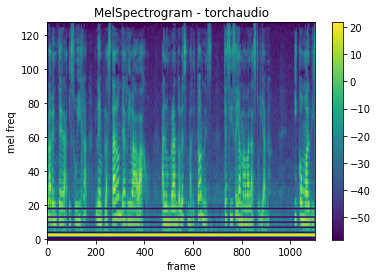

In [7]:
# Example
spectro = flac_to_spectro("/content/drive/MyDrive/neural networks project/test_set_es/data_sample/es_f_50298ab71aaba8508ebeef49d853df11.fragment17.flac")
plot_spectrogram(spectro[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [31]:
class SpeechDataset(Dataset):

    def __init__(self, flac_dir):
        self.audio_path_list = sorted(self.find_files(flac_dir))
        # Conversion into spectrogramms 
        self.specto_data = []
        for f_path in self.audio_path_list:
          self.specto_data.append(flac_to_spectro(f_path))
        # TODO Convert it into an actual image ? 

    def __len__(self):
        # return len(self.audio_path_list)
        return len(self.specto_data)

    def __getitem__(self, index):
        #audio_path = self.audio_path_list[index]
        #with open(audio_path, "rb") as f:
            #data, samplerate = sf.read(f)
        #return data, samplerate
        return self.specto_data[index]

    def find_files(self, directory, pattern="*.flac"):
        """
        Recursive search method to find files. Credit to Paul Magron for OG method
        """
        audio_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                audio_path_list.append(os.path.join(root, filename))

        return audio_path_list


# Step 2 : Define the Dataset and the different dataloaders

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.3439e+01, 7.0472e+01, 7.9670e+01,  ..., 8.4546e+01, 7.6135e+01,
         8.3885e+01],
        ...,
        [1.2670e-06, 3.4157e-06, 1.3525e-06,  ..., 5.0461e-06, 9.9038e-06,
         7.5141e-06],
        [1.4095e-06, 2.2633e-06, 1.4397e-06,  ..., 4.4975e-06, 5.5971e-06,
         2.9298e-06],
        [6.1388e-07, 2.1072e-07, 5.2045e-07,  ..., 8.1601e-07, 4.2068e-07,
         3.9496e-07]])


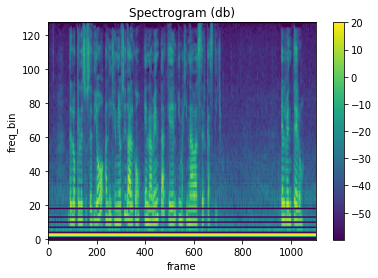

In [33]:
data_dir = "/content/drive/MyDrive/neural networks project/test_set_es/data_sample/"

# Prepare the Dataset
dataset = SpeechDataset(flac_dir=data_dir)

# Small example 
features_example = dataset.specto_data[0][0]
print(features_example)
plot_spectrogram(features_example)


In [35]:
# Prepare the Dataloader
batch_size = 16  # TODO determine a decent batch size
speech_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_data = Subset(speech_dataloader, torch.arange(240)) # 80% 
test_data = Subset(speech_dataloader, torch.arange(60))  # 20%
print('Number of files in the train dataset', len(train_data))
print('Number of files in the test dataset', len(test_data))

# Create the dataloaders
batch_size = 16
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
print('Number of files in the train DataLoader', len(train_dataloader))
print('Number of files in the test DataLoader', len(test_dataloader))

Number of files in the train dataset 240
Number of files in the test dataset 60
Number of files in the train DataLoader 15
Number of files in the test DataLoader 4


# Step 3 : Define the classifier

In [38]:
# TODO this is just a filler I don't think this going to lead to good results :(

class SpectroClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(SpectroClassif, self).__init__()
        # TODO I guess we need use nn.Conv2d to process the images 
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), act_fn)
        self.hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), act_fn)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        out = self.output_layer(y)
        return out

# Step 4 : Define the eval and training functions 

# Step 5 : Train the model

# Step 6 : Adjusting